In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, declare them in the YAML spec and leave this
from darts.utils.utils import ModelMode, SeasonalityMode
from datetime import timedelta

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import plot_residuals_analysis
from darts.models import AutoARIMA, ARIMA, VARIMA, ExponentialSmoothing
from darts.metrics import rmse, mae

from hydro_timeseries.darts_utils import backtest_minute_data, exploratory_arima
from hydro_timeseries.plotting import plot_residuals, tsplot
from hydro_timeseries.pytorch_utils import pl_trainer_kwargs
from hydro_timeseries.util import load_timeseries_csv, add_mean_vars
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from darts.models import BlockRNNModel, RNNModel

from hydro_timeseries.variables import Variables

upstream = None

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-10-01"
simulate_from = "2021-12-01"
upstream = {"run-tests": {"nb": "/home/m/repo/hydro-power-prediction/reports/run_tests.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/data_raw_tested.csv"}}
product = {"nb": "/home/m/repo/hydro-power-prediction/reports/exploratory_darts_daily.ipynb"}


In [5]:
# your code here...
data = load_timeseries_csv(upstream['run-tests']['data'])
data = add_mean_vars(data)
data = data.dropna(axis = 0)

In [6]:
data_daily = data.resample('D').mean()

In [7]:
simulate_from = pd.to_datetime(simulate_from)
valid_from = pd.to_datetime(valid_from)

ts_minute = TimeSeries.from_dataframe(data)
ts = TimeSeries.from_dataframe(data_daily)
covariates = ts[Variables.meteo_means_i]
train_until = valid_from - timedelta(days=1)

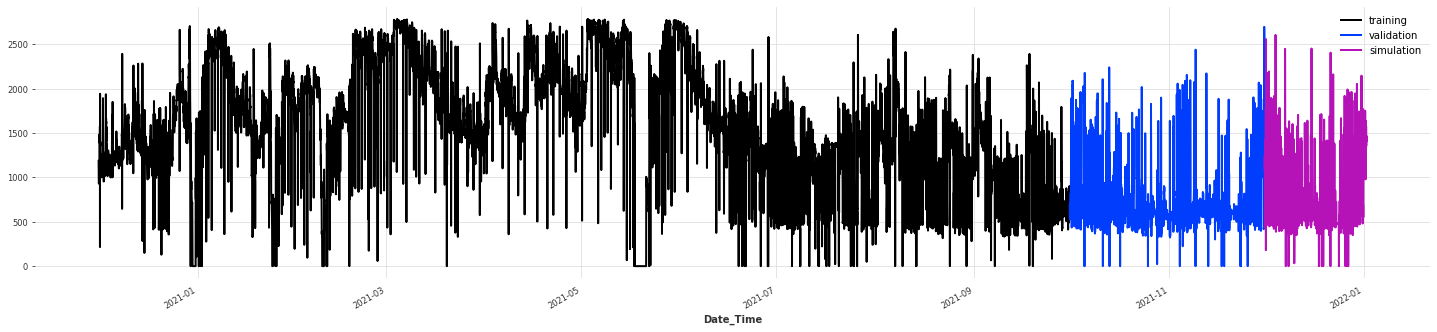

In [8]:
plt.figure(100, figsize=(25, 5))
ts_minute[:valid_from]['Value'].plot(label="training")
ts_minute[valid_from:simulate_from]['Value'].plot(label="validation")
ts_minute[simulate_from:]['Value'].plot(label="simulation")
plt.show()

In [9]:
'''
ARIMA(2,1,1) on daily mean to observe covariates
- 1 no covariates
- 2 means across stations
- 3 all precip covariates

- Conclusion = most information in the target? 
'''
print("No covariates")
exploratory_arima(ts[:train_until]['Value'], covariates=None)

No covariates
Performing stepwise search to minimize bic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=4277.157, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4281.109, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=4285.296, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=4285.224, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=4275.404, Time=0.01 sec


 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=4275.756, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.427 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  304
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2122.274
Date:                Wed, 24 Aug 2022   AIC                           4252.547
Time:                        12:33:18   BIC                           4267.402
Sample:                             0   HQIC                          4258.490
                                - 304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9586      0.040     24.193      0.000       0.881 

/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [10]:
print("Mean covariate")
exploratory_arima(ts[:train_until]['Value'], covariates=ts[:train_until][Variables.meteo_means_i])

Mean covariate
Performing stepwise search to minimize bic


 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=4390.217, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=4691.557, Time=0.09 sec


 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=4332.039, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=4547.549, Time=0.14 sec


 ARIMA(0,0,0)(0,0,0)[0]             : BIC=4742.811, Time=0.11 sec


 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=4354.376, Time=0.36 sec


 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=4353.334, Time=0.42 sec


 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=4367.900, Time=0.48 sec


 ARIMA(1,0,0)(0,0,0)[0]             : BIC=4327.506, Time=0.35 sec


 ARIMA(2,0,0)(0,0,0)[0]             : BIC=4363.080, Time=0.40 sec


 ARIMA(1,0,1)(0,0,0)[0]             : BIC=4361.539, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=4542.453, Time=0.12 sec


 ARIMA(2,0,1)(0,0,0)[0]             : BIC=4370.903, Time=0.41 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 4.122 seconds


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


x1 temperature_mean
x2 evapotranspiration_mean
x3 snow_mean
x4 soil_moisture_mean
x5 pressure_mean
x6 precip_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  304
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2119.570
Date:                Wed, 24 Aug 2022   AIC                           4259.139
Time:                        12:33:23   BIC                           4296.276
Sample:                             0   HQIC                          4273.996
                                - 304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            42.0424    406.772      0.103      0.918    -755.216     839.301
x2          -404.

In [11]:
print("Precip covariate")
exploratory_arima(ts[:train_until]['Value'], covariates=ts[:train_until][Variables.precip])

Precip covariate
Performing stepwise search to minimize bic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=4301.567, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4307.181, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=4310.337, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=4310.241, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=4301.476, Time=0.10 sec


 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=4315.928, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.761 seconds


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


x1 precip_20
x2 precip_40
x3 precip_75
x4 precip_81
x5 precip_104
x6 precip_134
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  304
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2117.326
Date:                Wed, 24 Aug 2022   AIC                           4254.652
Time:                        12:33:24   BIC                           4291.789
Sample:                             0   HQIC                          4269.509
                                - 304                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           228.7881    160.166      1.428      0.153     -85.131     542.708
x2          -640.8540    554.885     -1.155      0.

In [12]:
cov_scaler = Scaler()
value_scaler = Scaler()
covariates_daily = ts[Variables.meteo_means_i]
covariates_daily_scaled = cov_scaler.fit_transform(ts[Variables.meteo_means_i])
value_daily_scaled = value_scaler.fit_transform(ts['Value'])

train_scaled = value_daily_scaled[:train_until]

In [13]:
train, val = value_daily_scaled.split_before(valid_from)
train_covs, val_covs = covariates_daily_scaled.split_before(valid_from)

In [14]:
val, sim = val.split_before(simulate_from)
val_covs, sim_covs = val_covs.split_before(simulate_from)

  0%|          | 0/31 [00:00<?, ?it/s]

/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


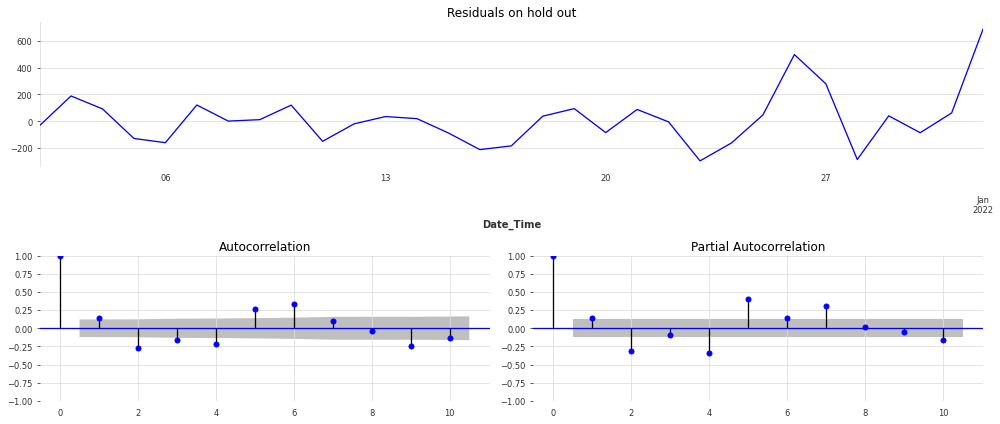

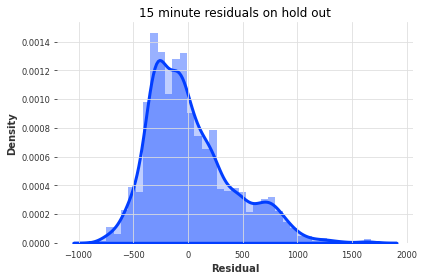

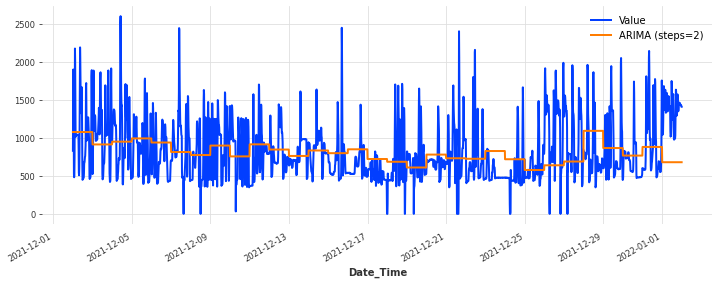

ARIMA n_val=2976 SMAPE=36.82 RMSE=388.00 MAE=302.46


In [15]:
'''
Day ahead backtest on hold out
'''
arima = ARIMA(p=2, d=1, q=1, trend=None)

backtest, ts_eval, rmse_val, mae_val, smape_val = backtest_minute_data(arima, ts['Value'],
                                                   data_df=data, valid_from=simulate_from,
                                                   future_covariates=covariates_daily_scaled['precip_mean'],
                                                   forecast_horizon=2, scaler=None
                                                   )

  0%|          | 0/31 [00:00<?, ?it/s]

/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


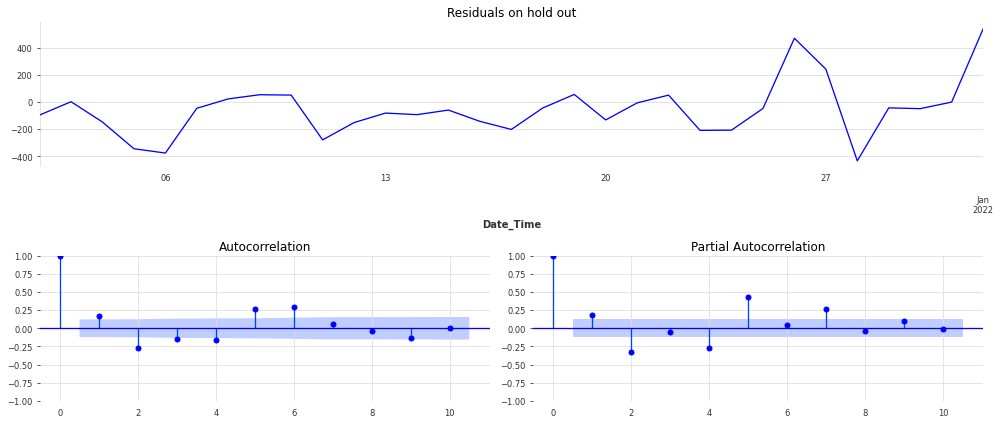

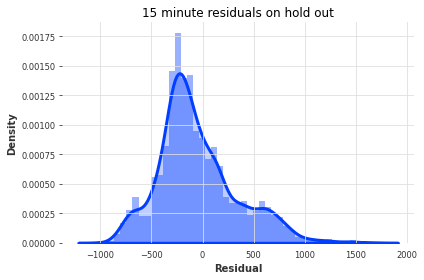

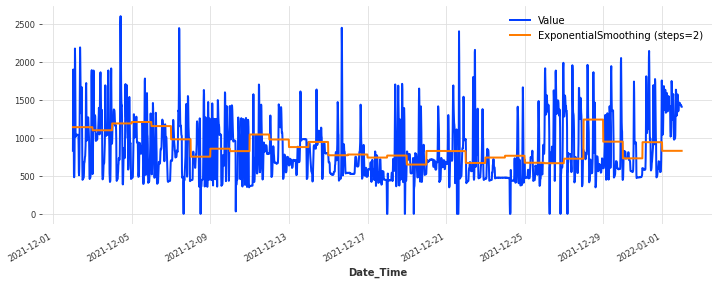

ExponentialSmoothing n_val=2976 SMAPE=37.37 RMSE=391.96 MAE=312.54


In [16]:
'''
Exponential smoothing
'''
exp_smooth = ExponentialSmoothing(trend=ModelMode.ADDITIVE)

backtest, ts_eval, rmse_val, mae_val, smape_val = backtest_minute_data(exp_smooth, ts['Value'],
                     data_df=data, valid_from=simulate_from,
                     forecast_horizon=2, scaler=None
                    )

In [17]:
'''
Simple RNN
'''
value_scaler = Scaler()
value_daily_scaled = value_scaler.fit_transform(ts['Value'])

2022-08-24 12:33:35 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 273 samples.


2022-08-24 12:33:35 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.


2022-08-24 12:33:35 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False


2022-08-24 12:33:35 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores


2022-08-24 12:33:35 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs


2022-08-24 12:33:35 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
2022-08-24 12:33:35 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 52    
---------------------------------------------------
752       Trainable params
0         Non-trainable params
752       Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

Predicting: 9it [00:00, ?it/s]

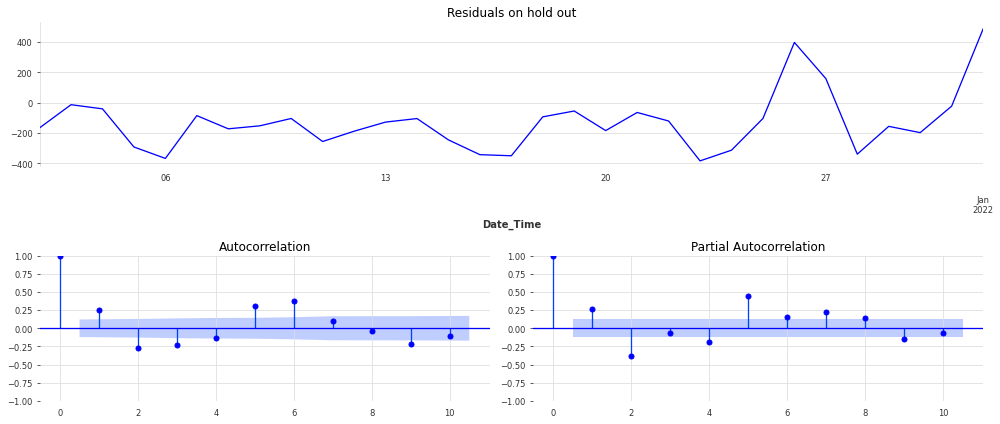

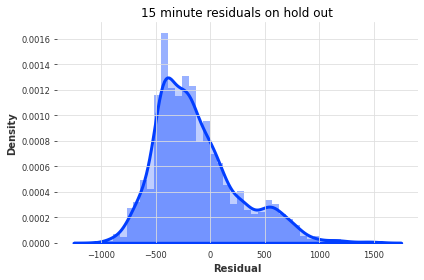

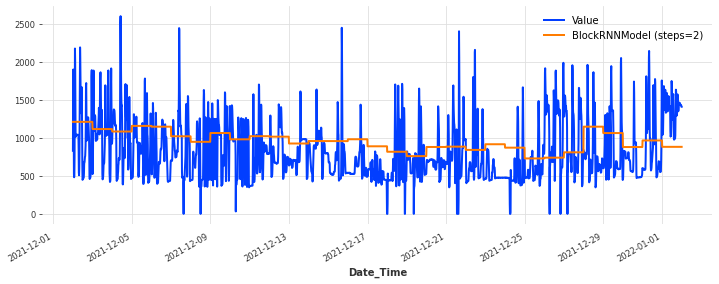

BlockRNNModel n_val=2976 SMAPE=40.20 RMSE=404.83 MAE=337.90


In [18]:
'''
Simple RNN for daily = approx ARIMA
'''
brnn_no_cov = BlockRNNModel(input_chunk_length=30,
                            output_chunk_length=2,
                            n_rnn_layers=1)

brnn_no_cov.fit(train,
                epochs=100,
                verbose=True,
                val_series = val
                )

backtest, ts_eval, rmse_val, mae_val, smape_val = backtest_minute_data(brnn_no_cov, value_daily_scaled, scaler = value_scaler,
                                   data_df=data, valid_from=simulate_from, retrain=False)

In [19]:
'''
RNN with past covariates
'''
soil_moisture = covariates_daily_scaled[['soil_moisture_mean']]
# rain = covariates_daily['precip_mean']

brnn_past = BlockRNNModel(input_chunk_length=50,
                         output_chunk_length=2,
                         n_rnn_layers=3)

brnn_past.fit(train,
             past_covariates=train_covs['soil_moisture_mean'],
             val_series=val,
             val_past_covariates=val_covs['soil_moisture_mean'],
             epochs=200,
             verbose=True)

2022-08-24 12:33:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 253 samples.


2022-08-24 12:33:51 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.


2022-08-24 12:33:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False


2022-08-24 12:33:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores


2022-08-24 12:33:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs


2022-08-24 12:33:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
2022-08-24 12:33:51 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 3.3 K 
4 | fc            | Sequential       | 52    
---------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

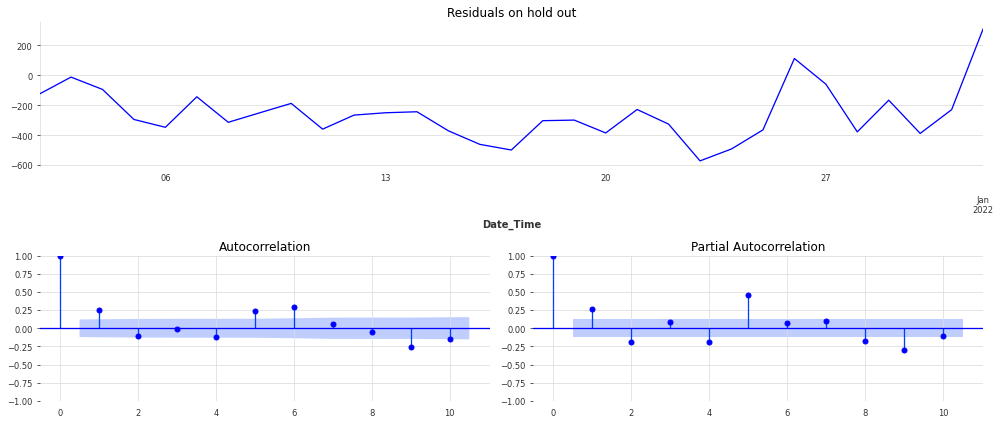

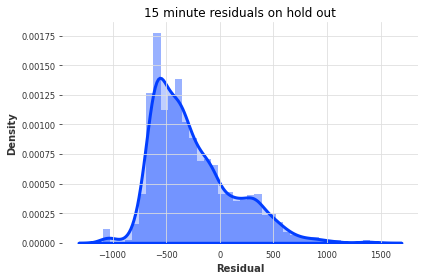

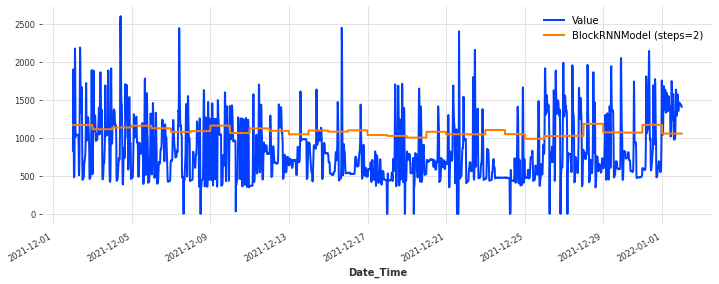

BlockRNNModel n_val=2976 SMAPE=45.93 RMSE=456.14 MAE=400.83


In [20]:
backtest, ts_eval, rmse_val, mae_val, smape_val = backtest_minute_data(brnn_past, value_daily_scaled,
                                data_df=data, valid_from=simulate_from,
                                past_covariates=soil_moisture,
                                scaler = value_scaler, retrain=False
                                )

In [21]:
'''
GRU + future covariates 330 RMSE
'''

future_cov = covariates_daily_scaled[['precip_mean', 'pressure_mean']]

'''
Generally speaking, `training_length` should have a higher value than `input_chunk_length`
because otherwise during training the RNN is never run for as many iterations as it will during
training.
'''

rnn_rain = RNNModel(input_chunk_length=3,
                    training_length=5,
                    model='GRU',
                    n_rnn_layers=2,
                    dropout=0.5
                    )

rnn_rain.fit(train,
             future_covariates=train_covs[['precip_mean', 'temperature_mean']],
             val_series=val,
             val_future_covariates=val_covs[['precip_mean', 'temperature_mean']],
             epochs=100,
             verbose=True)

2022-08-24 12:34:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 299 samples.


2022-08-24 12:34:38 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.


2022-08-24 12:34:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False


2022-08-24 12:34:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores


2022-08-24 12:34:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs


2022-08-24 12:34:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
2022-08-24 12:34:38 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 6.2 K 
4 | V             | Linear           | 26    
---------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

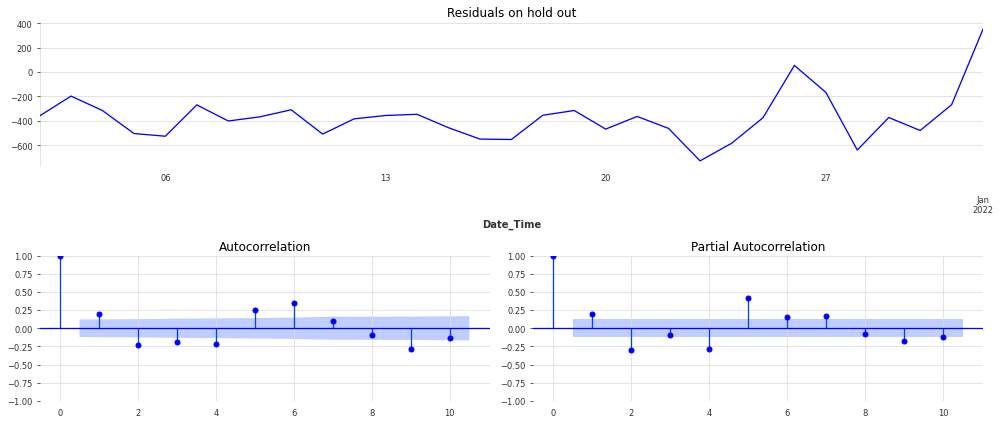

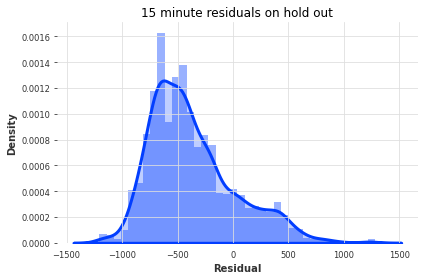

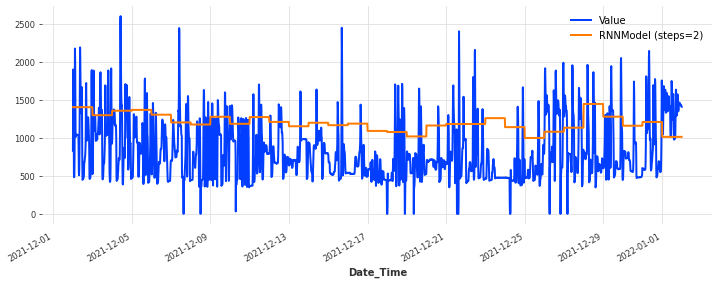

RNNModel n_val=2976 SMAPE=51.58 RMSE=536.96 MAE=476.58


In [22]:

backtest, ts_eval, rmse_val, mae_val, smape_val = backtest_minute_data(rnn_rain, value_daily_scaled,
                                   data_df=data, valid_from=simulate_from,
                                   # past_covariates=soil_moisture,
                                   future_covariates=covariates_daily_scaled[['precip_mean', 'temperature_mean']],
                                   scaler = value_scaler, retrain=False
                             )

In [23]:
'''
RegressionModel

- Past covariates are time series whose past values are known at prediction time. Those series often contain values that have to be observed to be known.
- Future covariates are time series whose future values are known at prediction time. More precisely, for a prediction made at time t for a forecast horizon n, the values at times t+1, …, t+n are known. Often, the past values (for times t-k, t-k+1, …, t for some lookback window k) of future covariates are known as well. Future covariates series contain for instance calendar informations or weather forecasts.

The lags of the target and past covariates have to be strictly negative (in the past), 
whereas the lags of the future covariates can also be positive (in the future). 
For instance, a lag value of -5 means that the value at time t-5 is used to predict the target at time t; and a lag of 0 means that the future covariate value at time t is used to predict the target at time t. 
In the code below, we specify past covariate lags as [-5, -4, -3, -2, -1] which means that the model will look at the last 5 past_covariates values
Similarly, we specify the future covariate lags as [-4, -3, -2, -1, 0] which means that the model will look at the last 4 historic values (lags -4 to -1) and the current value (lag 0) of the future_covariates.

'''
rain = train_covs['precip_mean']
soil = train_covs['soil_moisture_mean']

future_covs_regr = train_covs[['precip_mean','soil_moisture_mean']]

from darts.models import RegressionModel

regr_model = RegressionModel(lags=[-5,-4,-3,-2],
                             # lags_past_covariates=[-3, -2, -1],
                             lags_future_covariates=[ -2, -1, 0])

regr_model.fit(train,
               # past_covariates=soil,
               future_covariates=future_covs_regr
               )

  0%|          | 0/31 [00:00<?, ?it/s]

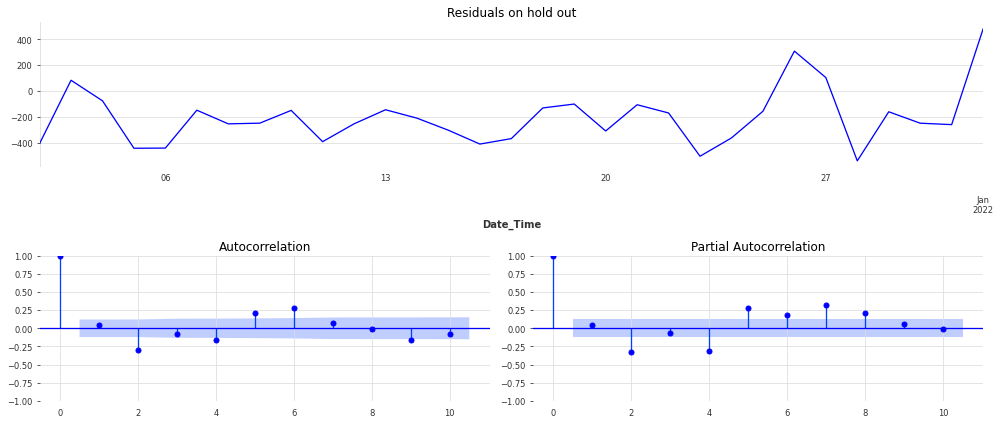

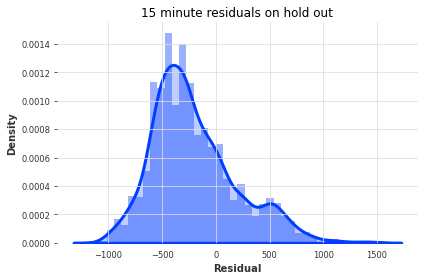

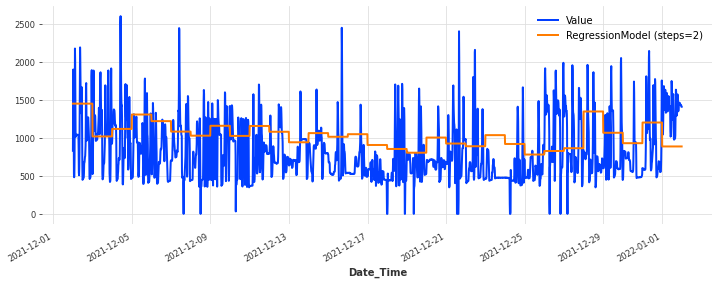

RegressionModel n_val=2976 SMAPE=43.83 RMSE=446.46 MAE=380.68


In [24]:
backtest, ts_eval, rmse_val, mae_val, smape_val = backtest_minute_data(regr_model, value_daily_scaled,
                                   # past_covariates=covariates_daily_scaled['soil_moisture_mean'],
                                   future_covariates=covariates_daily_scaled[['precip_mean','soil_moisture_mean']],
                                   data_df=data, valid_from=simulate_from,
                                   scaler = value_scaler, retrain=False
                             )

